# Consume from Kafka, plot the result
### To run this notebook, please [follow the instructions](https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html) or else it won`t work.
The instructions are at https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html

This notebook reads from a Lasair active filter that has the `lite lightcurve` setting, so that the lightcurve is delivered 
along with the selected attributed of the filter. For more information, see
https://lasair-lsst.readthedocs.io/en/main/core_functions/alert-streams.html

In [91]:
import sys, json, time
import matplotlib.pyplot as plt
from lasair import LasairError, lasair_consumer
kafka_server = 'lasair-lsst-kafka.lsst.ac.uk:9092'

The `topic` comes from the active filter that you are reading from. You should change this to be your own filter. 
Remember there may be nothing to read until some alerts have come to Lasair and passed through your filter.
Note that we are assuming it was saved with the `lightcurve-lite` setting. 
The `group_id` is an arbitrary string, a sort of bookmark in the kafka stream.

In [92]:
topic        = "lasair_2lightweight_lite"
group_id     = 'test127'
consumer = lasair_consumer(kafka_server, group_id, topic)

This function plots the flux of the `diaSources` and the `diaForcedSources`

In [93]:
bandColors = {'u': '#9900cc', 'g': '#3366ff', 'r':'#33cc33', 'i':'#ffcc00', 'z':'#ff0000', 'y':'#cc6600'}

def plot(diaObjectId, alert):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1)
    for band,color in bandColors.items():
        # the diaSources as blob marker
        mjd = []
        flux = []
        fluxErr = []
        for ds in alert['diaSourcesList']:
            if ds['band'] == band:
                mjd    .append(ds['midpointMjdTai'])
                flux   .append(ds['psfFlux'])
                fluxErr.append(ds['psfFluxErr'])
        ax.errorbar(mjd, flux, yerr=fluxErr, fmt='o', c=color, label=band)

        # now do the forced sources ax x marker
        mjdf = []
        fluxf = []
        fluxfErr = []
        for dfs in alert['diaForcedSourcesList']:
            if ds['band'] == band:
                mjdf    .append(dfs['midpointMjdTai'])
                fluxf   .append(dfs['psfFlux'])
                fluxfErr.append(dfs['psfFluxErr'])
        ax.errorbar(mjdf, fluxf, yerr=fluxfErr, fmt='x', c=color)
        
        ax.legend()
        plt.xlabel("MJD")
        plt.ylabel("flux (nJ)")
        plt.title('https://lasair.lsst.ac.uk/objects/%s' % diaObjectId)
    plt.show()

Start the Kafka consumer. Sometimes it takes a few seconds to start; really the consumer expects to be a long-lived object.

sleeping 5 sec
sleeping 5 sec
sleeping 5 sec
sleeping 5 sec
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 3 diaSources


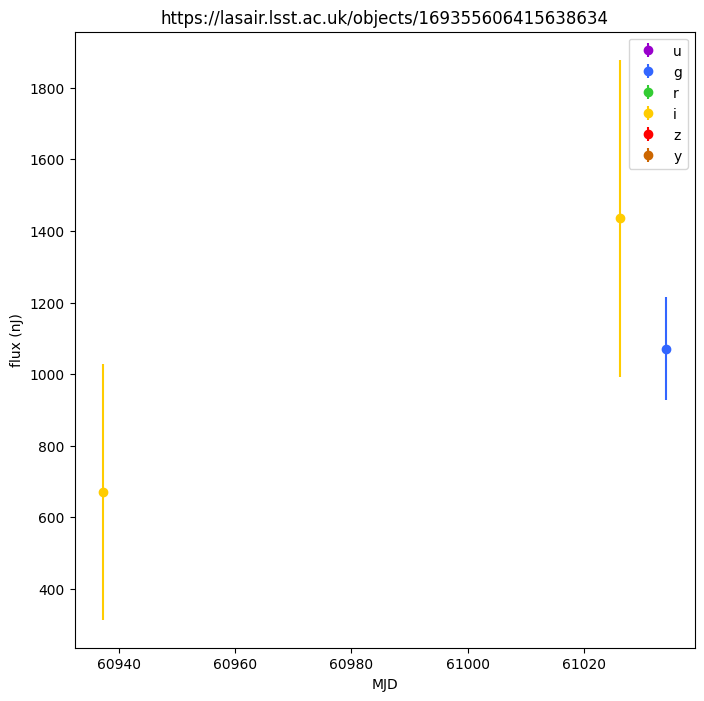

Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:12:02 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 37 diaSources


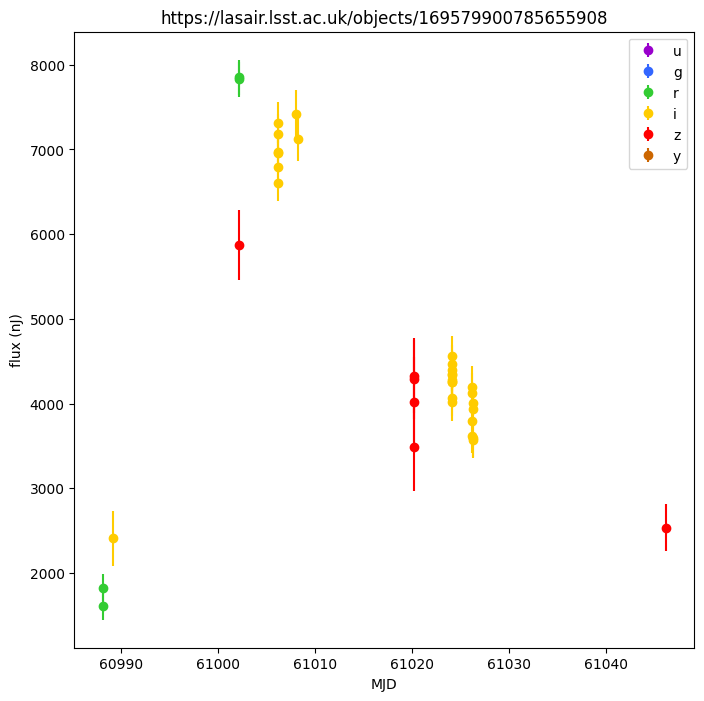

Record made at 2026-01-31 09:30:49 with 8 diaSources


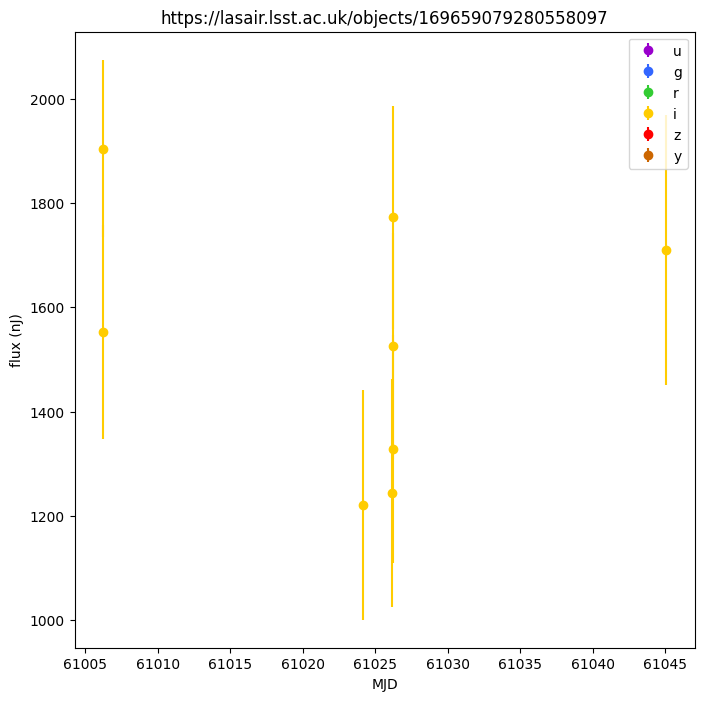

Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Record made at 2026-01-31 09:30:49 with 1 diaSources
Fetched 20 messages


In [94]:
nalert = 0
nsleep = 0
while nalert < 20:
    msg = consumer.poll(timeout=5)
    if msg is None:
        print('sleeping 5 sec')  # sometimes the kafka takes a while to wake up
        time.sleep(5)
        nsleep += 1
        if nsleep < 10:  continue
        else:            break
    if msg.error():
        print(str(msg.error()))
        break

    # we have a valid message, now convert the JSON to a Python object
    jmsg = json.loads(msg.value())

    diaObjectId = jmsg['diaObjectId']
    utc         = jmsg['UTC']
    alert       = jmsg['alert']
    nds         = len(alert['diaSourcesList'])
    print(f'Record made at {utc} with {nds} diaSources')

    # Plot those with more than 2 diaSources
    if nds > 2:
        plot(diaObjectId, alert)
    nalert += 1
print(f'Fetched {nalert} messages')